In [1]:
from ybco import *
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.optimize import curve_fit
from scipy.io import savemat

# 1$^{st}$ pass

##### Python code 1st pass (no time bins, only laser OFF shots!):
##### Run number
##### ROI
##### Energy threshold
##### I0 threshold
##### Output:
##### ROI image
##### Combined projection – select integration region
##### CDW integrated signal vs std. dev
##### Scope:
##### Cycle over energy threshold parameters and I0 parameters.
##### Test normalization methods

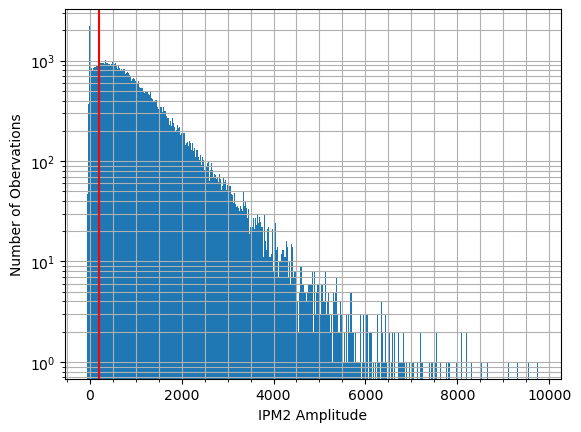

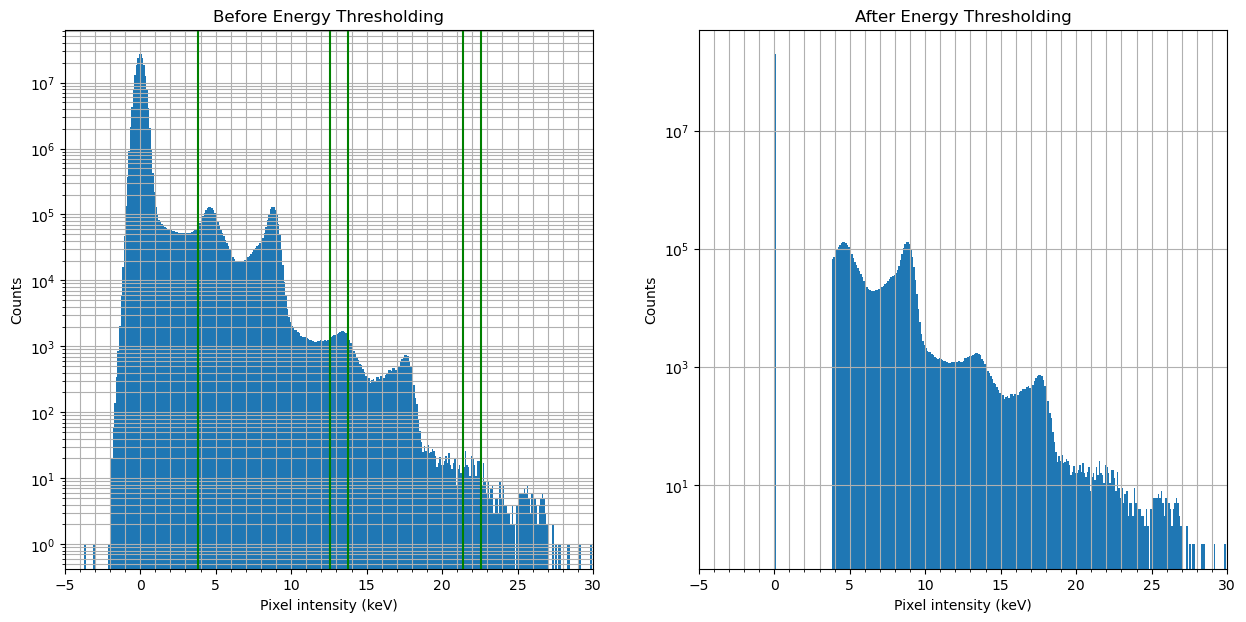

In [2]:
Run_Number = 195
ROI = [5,105,50,250]
Energy_Filter = [8.8,5]
I0_Threshold = 200
aimg,simg, imgs_thresh, evt_filter = CDW_Optimizer(Run_Number, ROI, Energy_Filter, I0_Threshold)

In [24]:
%run histogram_analysis.py

In [4]:
from scipy.stats import wasserstein_distance
from scipy.ndimage import label

# Redefine bin boundaries
# bin_boundaries = np.arange(-10, 30, 0.1)
bin_boundaries = np.arange(5, 30, 0.2)
hist_start_bin = 1

# Define parameters
roi_x_start, roi_x_end = 50, 100
roi_y_start, roi_y_end = 0, 200

data = imgs_thresh#[:500, ...]#load_data(filepath)
histograms = calculate_histograms(data, bin_boundaries, hist_start_bin)

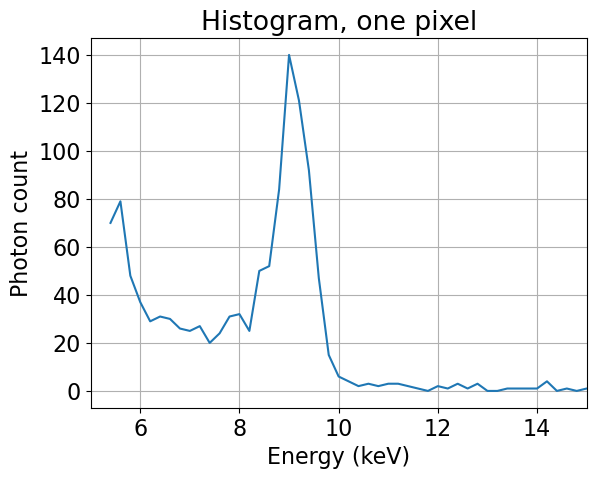

In [35]:
import matplotlib.pyplot as plt

# Increase font size for labels and tick labels
plt.rcParams.update({'font.size': 16})  # You can adjust the font size as needed

energies = bin_boundaries[hist_start_bin + 1:]

plt.plot(energies, histograms[:, 50, 50])
plt.xlabel('Energy (keV)')
plt.ylabel('Photon count')
plt.title('Histogram, one pixel')
plt.xlim((5, 15))
plt.grid()

plt.show()


In [25]:
# Run the analysis to obtain the actual data
_, p_values, _, roi_connected_cluster, _ = run_histogram_analysis(
    data, bin_boundaries, hist_start_bin, roi_x_start, roi_x_end, roi_y_start, roi_y_end,
    threshold = .1)
filtered_clusters = filter_negative_clusters_by_size(roi_connected_cluster, M=50)

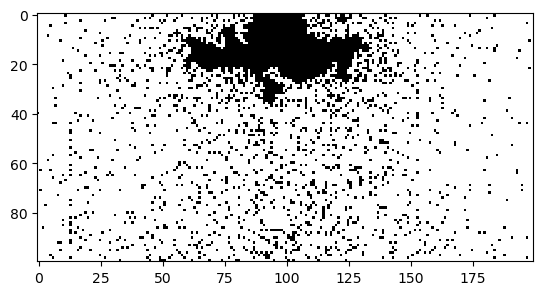

In [26]:
plt.imshow(roi_connected_cluster, interpolation = 'none', cmap = 'gray')

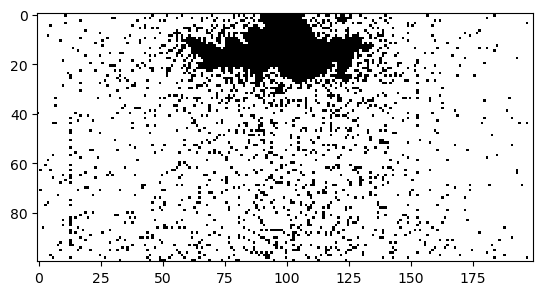

In [9]:
plt.imshow(roi_connected_cluster, interpolation = 'none', cmap = 'gray')

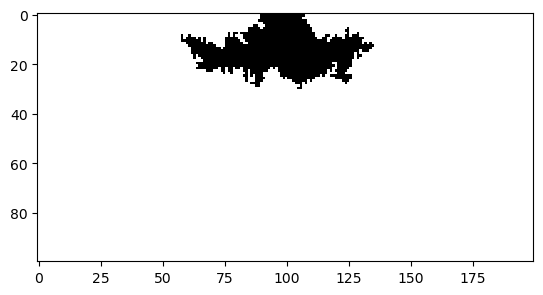

In [10]:
plt.imshow(filtered_clusters, interpolation = 'none', cmap = 'gray')

In [53]:
imgs_sum[filtered_clusters].mean(), imgs_sum[~filtered_clusters].mean()

(12074.578, 12783.718)

## TODO move all this into a module

In [27]:
from functools import partial
import matplotlib.pyplot as plt
from ipywidgets import interact, widgets

# from your_module import run_histogram_analysis, filter_negative_clusters_by_size  # Replace 'your_module' with the actual module name

# TODO refactor
imgs_sum = data.sum(axis = 0)
def rectify_filter_mask(mask):
    if mask.sum() == 0:
        return ~mask
    mean_1 = imgs_sum[mask].mean()
    mean_0 = imgs_sum[~mask].mean()
    if mean_1 < mean_0:
        return mask
    else:
        return ~mask
    
from scipy.ndimage import label

def infill_binary_array(data, array):
    imgs_sum = data.sum(axis = 0)
    def rectify_filter_mask(mask):
        if mask.sum() == 0:
            return ~mask
        mean_1 = imgs_sum[mask].mean()
        mean_0 = imgs_sum[~mask].mean()
        if mean_1 < mean_0:
            return mask
        else:
            return ~mask
        
    # Label connected components
    labeled_array, num_features = label(
        rectify_filter_mask(
            array))
    
    # Find the largest component
    largest_component = 0
    largest_size = 0
    for i in range(1, num_features + 1):
        size = np.sum(labeled_array == i)
        if size > largest_size:
            largest_size = size
            largest_component = i
            
    # Create new binary image
    infilled_array = (labeled_array == largest_component)
    
    return infilled_array

    
M_value = 50

@memoize_general
def precompute_analysis_data(data, bin_boundaries, hist_start_bin, roi_x_start, roi_x_end, roi_y_start, roi_y_end, M_value, threshold_values):
    """
    Precomputes the analysis outputs for different threshold values and stores them in a dictionary.
    """
    np.random.seed(1)
    precomputed_data = {}
    
    for threshold in threshold_values:
        _, p_values, _, roi_connected_cluster, _ = run_histogram_analysis(
            data, bin_boundaries, hist_start_bin, roi_x_start, roi_x_end, roi_y_start, roi_y_end, threshold=threshold)
                
        filtered_clusters = filter_negative_clusters_by_size(
            rectify_filter_mask(
                roi_connected_cluster), M=M_value)
        
        # TODO refactor, this should go into run_histogram_analysis
        # Also run_histogram_analysis should return a dict
        filtered_clusters = infill_binary_array(data,
                                                filtered_clusters)
        
        precomputed_data[threshold] = {
            'p_threshold_mask': p_values > threshold,
            'filtered_clusters': filtered_clusters
        }
    
    return precomputed_data


In [28]:
# Assuming precomputed_data is generated before running this block of code

step = .02
threshold_values = np.arange(step, .4 + step, step) 
threshold_values = list(map(lambda x: round(float(x), 2),
                            threshold_values))

precomputed_data = precompute_analysis_data(data, bin_boundaries,
        hist_start_bin, roi_x_start, roi_x_end, roi_y_start,
        roi_y_end, M_value, threshold_values)

In [29]:
# Wrapper function to encapsulate the entire workflow
def interactive_histogram_analysis(data, bin_boundaries, hist_start_bin, roi_x_start, roi_x_end, roi_y_start, roi_y_end, M_value, threshold_values, step):
    # Precompute data
    precomputed_data = precompute_analysis_data(data, bin_boundaries, hist_start_bin, roi_x_start, roi_x_end, roi_y_start, roi_y_end, M_value, threshold_values)

    # Calculate imgs_sum
    imgs_sum = data.sum(axis=0)
    
    # Define update_visualization as a closure
    def update_visualization_closure(threshold):
        update_visualization(precomputed_data, threshold, imgs_sum)
    
    # Generate the interactive plot
    threshold_slider = widgets.FloatSlider(
        value=min(threshold_values),
        min=min(threshold_values),
        max=max(threshold_values),
        step=step,
        description='Threshold:',
        continuous_update=False
    )
    
    interact(update_visualization_closure, threshold=threshold_slider)


def update_visualization(precomputed_data, threshold, imgs_sum):
    """
    Update the imshow plots based on the selected threshold value.
    """  
    threshold = round(threshold, 2)
 
    data = precomputed_data[threshold]
    p_threshold_mask = data['p_threshold_mask']
    filtered_clusters = rectify_filter_mask(
        data['filtered_clusters'])
    
    fig = plt.figure(figsize=(12, 6))

    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 3, 1)
    plt.title('p threshold map')
    plt.imshow(p_threshold_mask, interpolation='none', cmap='gray')
    
    plt.subplot(1, 3, 2)
    plt.title(f'Final mask')
    plt.imshow(filtered_clusters, interpolation='none', cmap='gray')
    
    plt.subplot(1, 3, 3)
    plt.title(f'')
    plt.imshow((~filtered_clusters) * imgs_sum, interpolation='none',
               cmap='jet', vmin = 10000)
#     plt.colorbar()
    
    plt.show()    

In [30]:
interactive_histogram_analysis(data, bin_boundaries,
    hist_start_bin, roi_x_start, roi_x_end, roi_y_start, roi_y_end,
    M_value, threshold_values, step)

interactive(children=(FloatSlider(value=0.02, continuous_update=False, description='Threshold:', max=0.4, min=…

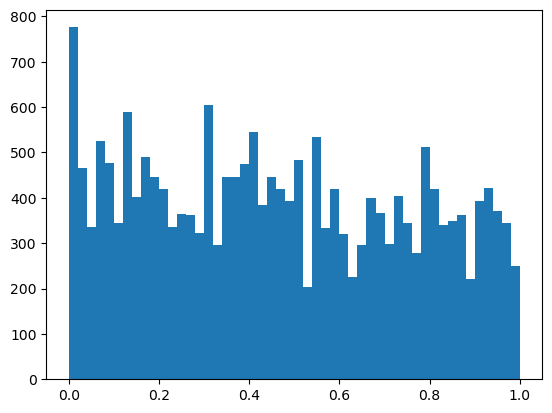

In [32]:
plt.hist(p_values.ravel(), bins = 50);

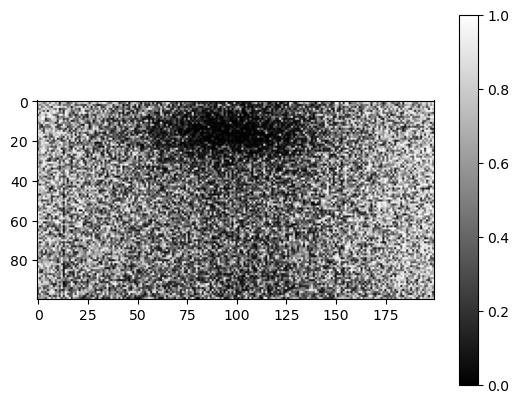

In [33]:
plt.imshow((p_values), cmap = 'gray')
plt.colorbar()

In [11]:
interactive_histogram_analysis(data, bin_boundaries,
    hist_start_bin, roi_x_start, roi_x_end, roi_y_start, roi_y_end,
    M_value, threshold_values, step)

interactive(children=(FloatSlider(value=0.02, continuous_update=False, description='Threshold:', max=0.4, min=…

In [15]:
# np.savez('mask.npz', precomputed_data[.2]['filtered_clusters'])

In [40]:
import matplotlib.pyplot as plt
import imageio

# def generate_frames(precomputed_data):
#     frames = []
#     for threshold, data in precomputed_data.items():
#         fig, axs = plt.subplots(2, 2, figsize=(12, 12))
        
#         # First Row
#         axs[0, 0].set_title('p threshold map')
#         im1 = axs[0, 0].imshow(data['p_threshold_mask'], interpolation='none', cmap='gray')
        
#         axs[0, 1].set_title('Final mask')
#         im2 = axs[0, 1].imshow(rectify_filter_mask(data['filtered_clusters']), interpolation='none', cmap='gray')
        
#         # Second Row
#         axs[1, 0].set_title('')
#         im3 = axs[1, 0].imshow((~rectify_filter_mask(data['filtered_clusters'])) * imgs_sum, interpolation='none', cmap='jet', vmin = 10000)
        
#         axs[1, 1].axis('off')  # Turn off the last plot if not used
        
#         # Include text that shows the threshold value for the frame
#         plt.figtext(0.5, 0.2, f'Threshold: {threshold}', ha="center", fontsize=12, bbox={"facecolor":"orange", "alpha":0.5})
        
#         # Capture the current frame as an image
#         fig.canvas.draw()
#         image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
#         image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        
#         frames.append(image)
        
#         plt.close(fig)
    
#     return frames


def generate_frames(precomputed_data):
    frames = []
    for threshold, data in precomputed_data.items():
        fig, axs = plt.subplots(1, 3, figsize=(12, 3))
        
        axs[0].set_title('p threshold map')
        im1 = axs[0].imshow(data['p_threshold_mask'], interpolation='none', cmap='gray')
        
        axs[1].set_title('Final mask')
        im2 = axs[1].imshow(rectify_filter_mask(data['filtered_clusters']), interpolation='none', cmap='gray')
        
        axs[2].set_title('')
        im3 = axs[2].imshow((~rectify_filter_mask(data['filtered_clusters'])) * imgs_sum, interpolation='none', cmap='jet', vmin = 10000)
        
        # Include text that shows the threshold value for the frame
        plt.figtext(0.5, 0.1, f'Threshold: {threshold}', ha="center", fontsize=12, bbox={"facecolor":"orange", "alpha":0.5})
        
        # Capture the current frame as an image
        fig.canvas.draw()
        image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        
        frames.append(image)
        
        plt.close(fig)
    
    return frames


# Step 2: Helper function to compose GIF
def compose_gif(frames, frame_rate):
    """
    Compose the frames into a GIF with the specified frame rate.
    """
    imageio.mimsave('animated_visualization.gif', frames, duration=frame_rate)

# Step 3: Main function to create GIF
def create_gif_from_data(precomputed_data, frame_rate=0.5):
    """
    Create a GIF from the precomputed_data with the specified frame rate.
    """
    frames = generate_frames(precomputed_data)
    compose_gif(frames, frame_rate)

# Path to the GIF file
gif_file_path = 'animated_visualization.gif'
create_gif_from_data(precomputed_data)

In [14]:
average_histogram = get_average_roi_histogram(histograms, roi_x_start, roi_x_end, roi_y_start, roi_y_end)
emd_values = calculate_emd_values(histograms, average_histogram)

num_permutations = 1000
null_distribution = generate_null_distribution(histograms, average_histogram, roi_x_start, roi_x_end, roi_y_start, roi_y_end,
                                              num_permutations)
p_values = calculate_p_values(emd_values, null_distribution)
labeled_array, roi_connected_cluster = identify_roi_connected_cluster(p_values, 0.2, roi_x_start, roi_x_end, roi_y_start, roi_y_end)

# emd_values, p_values, roi_connected_cluster


NameError: name 'histograms' is not defined

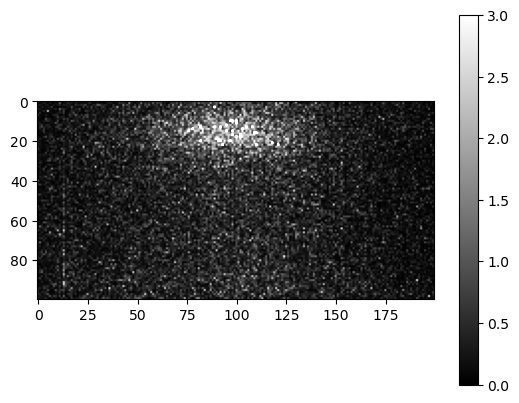

In [12]:
plt.imshow(-np.log10(p_values + 1e-9), cmap = 'gray', vmax = 3)
plt.colorbar()

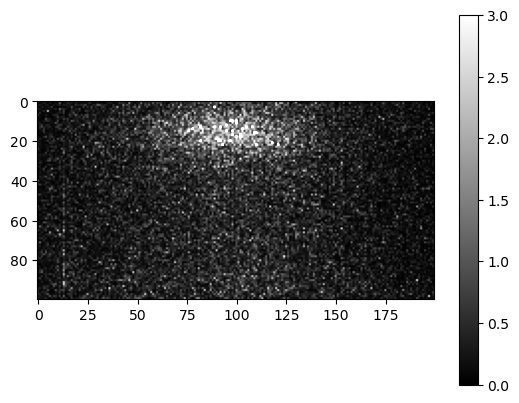

In [78]:
plt.imshow(-np.log10(p_values + 1e-9), cmap = 'gray', vmax = 3)
plt.colorbar()

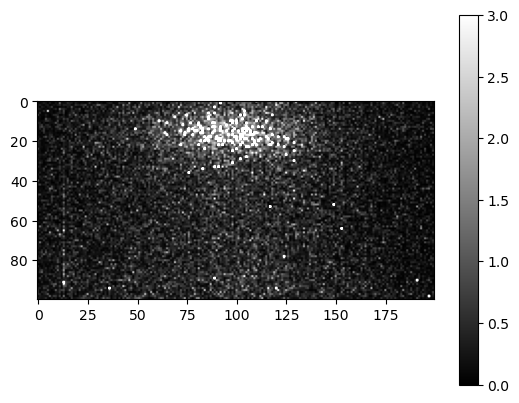

In [39]:
plt.imshow(-np.log10(p_values + 1e-9), cmap = 'gray', vmax = 3)
plt.colorbar()

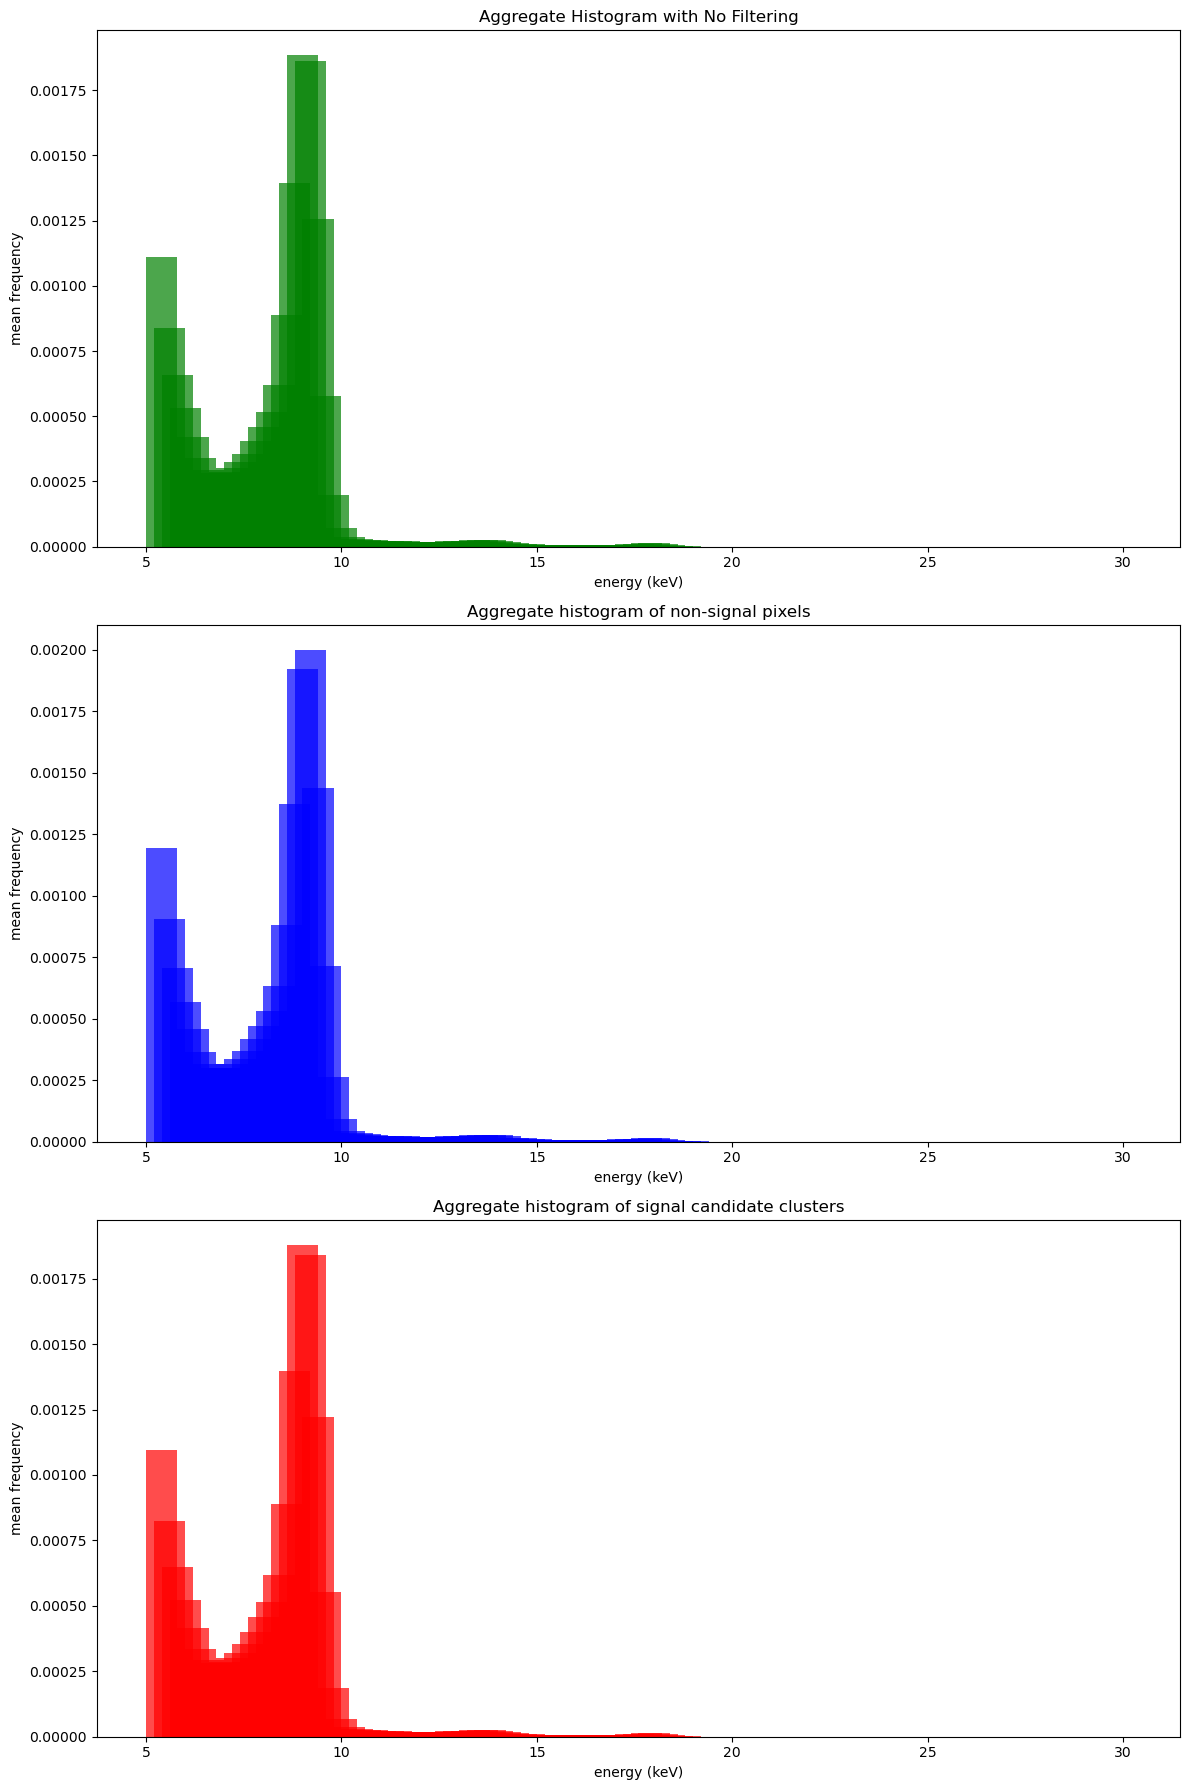

In [25]:
# Call the visualize_histogram_comparison function using the actual data
visualize_histogram_comparison(histograms, filtered_clusters, bin_boundaries, hist_start_bin)

In [22]:
np.savez('imgs_thresh_dirty.npz', imgs_thresh[:5, ...])

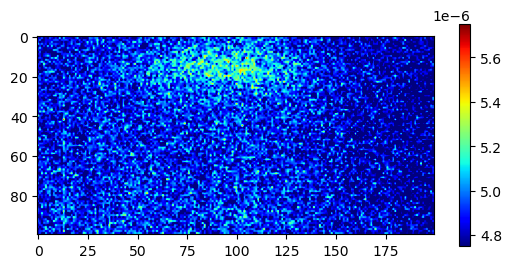

In [3]:
# check the standard deviation
plt.imshow(simg,clim=[4.75e-6,5.75e-6],cmap='jet')
plt.colorbar(shrink=0.6)
plt.show()

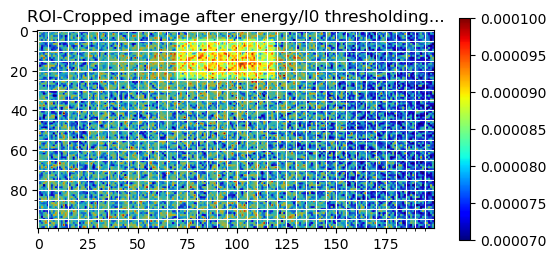

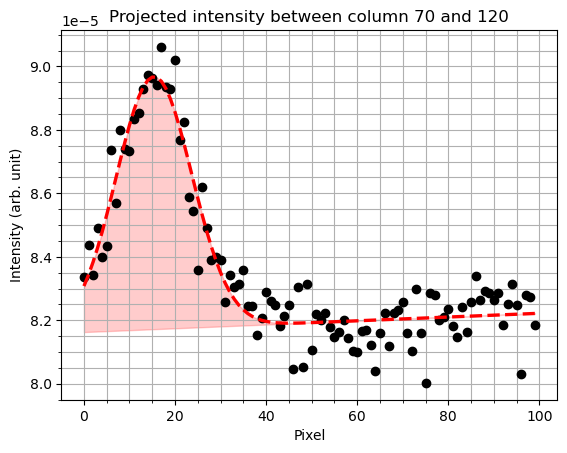

Signal over background ratio is: 0.097
Signal over uncertainity ratio is: 12.307


In [4]:
ROI_FG = [5,25,70,120]
SNR_a,SNR_b = SNR_analysis(aimg,ROI_FG)

# 2$^{rd}$ pass

##### Python code 2nd pass (pump-probe signal quick eval)
##### Run number
##### ROI
##### Optimal energy threshold
##### Optimal I0 threshold
##### IPM2 position threshold/filter
##### Time bins (meaning number to divide the time delay axis)
##### Output:
##### ROI image
##### Projections vs bins
##### CDW integrated signal vs time
##### Std. dev of integrated signal
##### Scope: evaluate normalization/filtering effect on pump-probe signal

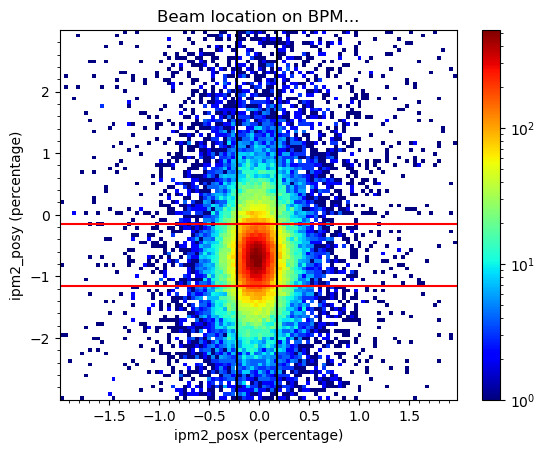

Number of laser delays is: 25, with an interval of 1.00 ps.


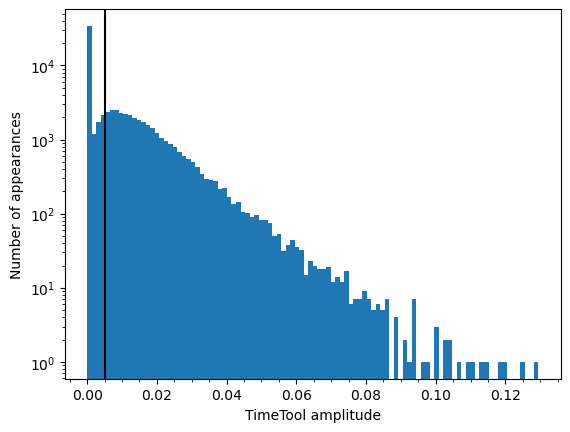

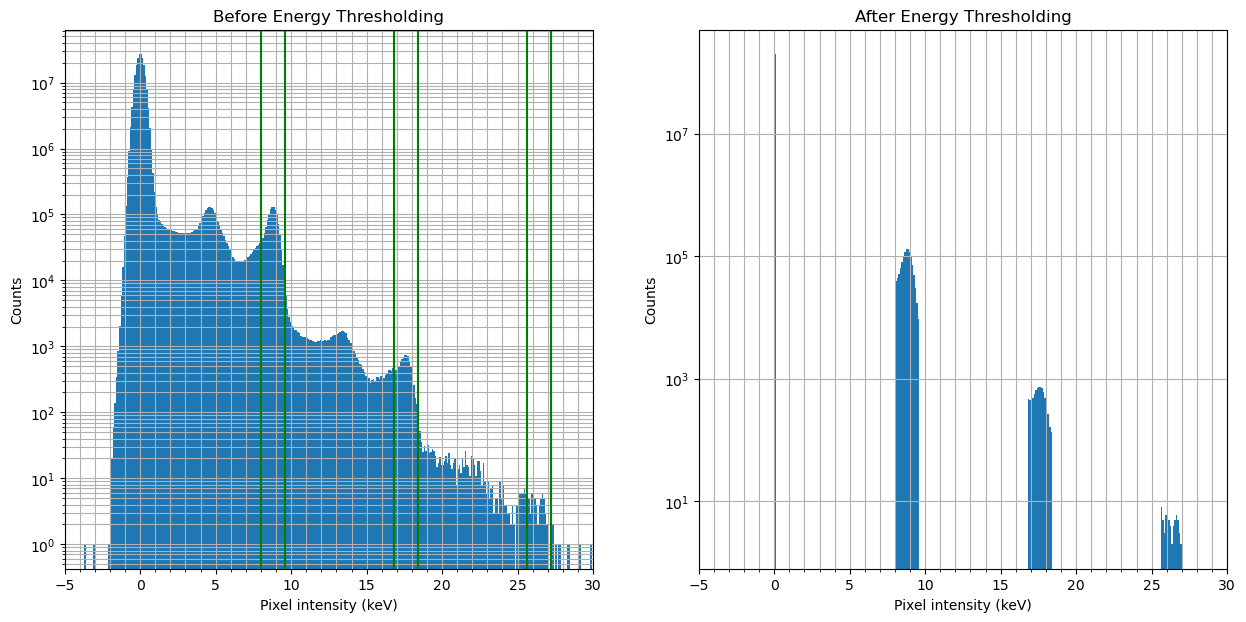

Working on the data of delay 25.43 ps...
Number of laser on and off events after filtering are 878/869.
Working on the data of delay 26.50 ps...
Number of laser on and off events after filtering are 762/650.
Working on the data of delay 27.49 ps...
Number of laser on and off events after filtering are 768/660.
Working on the data of delay 28.50 ps...
Number of laser on and off events after filtering are 783/674.
Working on the data of delay 29.50 ps...
Number of laser on and off events after filtering are 760/661.
Working on the data of delay 30.50 ps...
Number of laser on and off events after filtering are 726/648.
Working on the data of delay 31.50 ps...
Number of laser on and off events after filtering are 765/705.
Working on the data of delay 32.49 ps...
Number of laser on and off events after filtering are 795/652.
Working on the data of delay 33.50 ps...
Number of laser on and off events after filtering are 722/641.
Working on the data of delay 34.50 ps...
Number of laser on and 

In [5]:
IPM_pos_Filter, Time_bin, TimeTool = [0.2,0.5],1.,[1.,0.005]
delay,imgs_on,imgs_off  = CDW_PP(Run_Number, ROI, Energy_Filter, I0_Threshold, IPM_pos_Filter, Time_bin,TimeTool)

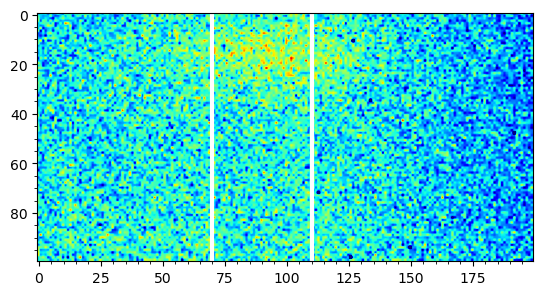

In [6]:
direction,boundary = 1,[70,110]
Intensity_on,Intensity_off = projection(imgs_on,imgs_off,direction,boundary)

In [10]:
data = {}
data['delay stage'] = delay
data['laser on images'] = imgs_on
data['laser off images'] = imgs_off
data['laser on traces'] = Intensity_on
data['laser off traces'] = Intensity_off

In [11]:
savemat("xppx1003221_processed_data_run.mat".format(Run_Number), data)

In [21]:
for i in range(len(delay)):
    print('Delay is {:} ps.'.format(delay[i]))
    fig,axs = plt.subplots(1,3,figsize=[12,3])
    clim1 = imgs_on[5:55,5:55].mean()-2*imgs_on[5:55,5:55].std()
    clim2 = imgs_on[5:55,5:55].mean()+3*imgs_on[5:55,5:55].std()
    axs[0].set_title('Laser on')
    im_on = cmap = axs[0].imshow(imgs_on[i],clim=[clim1,clim2],cmap='jet')
    axs[0].minorticks_on()
    cbar = plt.colorbar(im_on, ax=axs[0],shrink=0.5)
    
    axs[1].set_title('Laser off')
    im_off = cmap = axs[1].imshow(imgs_off[i],clim=[clim1,clim2],cmap='jet')
    axs[1].minorticks_on()
    cbar = plt.colorbar(im_off, ax=axs[1],shrink=0.5)
    
    axs[2].set_title('Projection')
    axs[2].plot(Intensity_on[i],label='Laser on')
    axs[2].plot(Intensity_off[i],label='Laser off')
    axs[2].minorticks_on()
    axs[2].set_xlabel('Pixel')
    axs[2].set_xlabel('Intensity')
    axs[2].legend()
    plt.subplots_adjust(wspace=0.8)
    plt.show()

NameError: name 'delay' is not defined